In [1]:
import findspark
findspark.init()

In [20]:
# %pip install seaborn==0.12.0

    100% |████████████████████████████████| 286kB 362kB/s ta 0:00:01
  Found existing installation: seaborn 0.11.0
    Uninstalling seaborn-0.11.0:
      Successfully uninstalled seaborn-0.11.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pandas import DataFrame
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pyspark.sql.window import Window
import seaborn as sns


spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

### Read data

In [ ]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
# df.printSchema()
# df.show()
# get_salary_frequency(df)
positionCategory:DataFrame=get_number_jobs_category(df)
positionCategory.show()

### Sample function

In [14]:
def get_salary_frequency(df: DataFrame) -> list:
    row_list = df.select('Salary Frequency').distinct().collect()
    return [row['Salary Frequency'] for row in row_list]

### Example of test function

In [8]:
mock_data = [('A', 'Annual'), ('B', 'Daily')]
expected_result = ['Annual', 'Daily']

In [10]:
def test_get_salary_frequency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['id', 'Salary Frequency']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert get_salary_frequency(mock_df) == expected_result

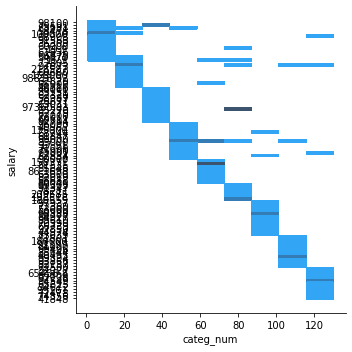

In [22]:
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True)
# df.printSchema()
# df.show()
# get_salary_frequency(df)
# positionCategory:DataFrame=get_number_jobs_category(df)
# positionCategory.show(truncate=False)
# highestPaidSkill = highest_paid_skill(df)
# highestPaidSkill.show()
# higestAgencySalary:DataFrame = highest_salary_per_agency(df)
# higestAgencySalary.show()
# avgAgencySalary:DataFrame = avg_salary_per_agency(df)
# avgAgencySalary.show() 
# print(avgAgencySalary.count())
# print(df.count())
# print("correlation ----> ",find_correlation(df))
# salary_dist_job_category(df)


### Whats the number of jobs posting per category (Top 10)?

In [5]:
def get_number_jobs_category(df:DataFrame)->DataFrame:
    res = df.groupBy("Job Category").agg(sum(col("# Of Positions")).alias("Number Of Position"))
    topTenRes = res.orderBy(col("Number Of Position").desc()).limit(10)
    return topTenRes

In [37]:
mock_data = [('Health', '358.0'), ('Public Safety, Inspections, & Enforcement', '1407.0'), ('Maintenance & Operations', '212.0'), ('Policy, Research & Analysis', '312.0')]
expected_result = [('Health', '358.0'), ('Public Safety, Inspections, & Enforcement', '1407.0'), ('Maintenance & Operations', '212.0'), ('Policy, Research & Analysis', '312.0')]
test_get_number_jobs_category(mock_data,expected_result)


In [36]:
def test_get_number_jobs_category(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Job Category', '# Of Positions']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    expected_df = spark.createDataFrame(data = expected_result, schema = schema)
    assert get_number_jobs_category(mock_df).subtract(expected_df).count() == 0
    

### What are the highest paid skills in the US market?

In [18]:
def highest_paid_skill(df:DataFrame)-> DataFrame:
    skillRes = df.groupBy("Preferred Skills").agg(max(col("Salary Range To")).alias("Max Salary"))
    higestPaid = skillRes.orderBy(col("Max Salary").desc())
    return higestPaid

In [35]:
mock_data = [('journalism', '96000'), ('accredited by regional', '97873'), ('individuals must have', '99406'), ('including the 18 months of executive', '99394')]
expected_result = [('journalism', '96000'), ('accredited by regional', '97873'), ('individuals must have', '99406'), ('including the 18 months of executive', '99394')]
test_highest_paid_skill(mock_data,expected_result)


In [34]:
def test_highest_paid_skill(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Preferred Skills', 'Salary Range To']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    expected_df = spark.createDataFrame(data = expected_result, schema = schema)
    assert highest_paid_skill(mock_df).subtract(expected_df).count() == 0
    

 ### Whats the job posting having the highest salary per agency?

In [29]:
def highest_salary_per_agency(df:DataFrame)->DataFrame:
    agencyRes = df.groupBy("Posting Type","Agency").agg(max(col("Salary Range To")).alias("Max Salary"))
    higestAgencyRes = agencyRes.orderBy(col("Max Salary").desc())
    return higestAgencyRes

In [33]:
mock_data = [('Internal','LAW DEPARTMENT', '96000'), ('Internal','POLICE DEPARTMENT', '97873'), ('External','LAW DEPARTMENT', '97000'), ('External','POLICE DEPARTMENT', '99873')]
expected_result = [('Internal','LAW DEPARTMENT', '96000'), ('Internal','POLICE DEPARTMENT', '97873'), ('External','LAW DEPARTMENT', '97000'), ('External','POLICE DEPARTMENT', '99873')]
test_highest_salary_per_agency(mock_data,expected_result)


In [32]:
def test_highest_salary_per_agency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Posting Type','Agency', 'Salary Range To']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    expected_df = spark.createDataFrame(data = expected_result, schema = schema)
    assert highest_salary_per_agency(mock_df).subtract(expected_df).count() == 0
    

### Whats the job positings average salary per agency for the last 2 years? 

In [38]:
def avg_salary_per_agency(df:DataFrame)->DataFrame:
    lastYearDate=(datetime.now() + relativedelta(years=-2)).strftime("%Y-%m-%d")+"T00:00:00"
    agencyRes = df.filter(col("`Posting Date`") >= lastYearDate)
    avgAgencyRes = agencyRes.groupBy("Posting Type","Agency").agg(avg(col("Salary Range To")).alias("Avg Salary"))
    return avgAgencyRes

In [55]:
mock_data = [('Internal','LAW DEPARTMENT', '96000','2023-04-01T00:00:00'), ('Internal','POLICE DEPARTMENT', '97873','2022-04-01T00:00:00'), ('External','LAW DEPARTMENT', '97000','2023-04-05T00:00:00'), ('External','POLICE DEPARTMENT', '99873','2022-04-31T00:00:00')]
expected_result = [('Internal','LAW DEPARTMENT', '96000.0','2023-04-01T00:00:00'), ('Internal','POLICE DEPARTMENT', '97873.0','2022-04-01T00:00:00'), ('External','LAW DEPARTMENT', '97000.0','2023-04-05T00:00:00'), ('External','POLICE DEPARTMENT', '99873.0','2022-04-31T00:00:00')]
test_avg_salary_per_agency(mock_data,expected_result)


In [54]:
def test_avg_salary_per_agency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Posting Type','Agency', 'Salary Range To','Posting Date']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    expected_df = spark.createDataFrame(data = expected_result, schema = schema).drop('Posting Date')
    assert avg_salary_per_agency(mock_df).subtract(expected_df).count() == 0


### Is there any correlation between the higher degree and the salary?

In [92]:
def find_correlation(df:DataFrame)->float:
    testDf = df.withColumn("salary",col("Salary Range To").cast('int'))
    testDf=testDf.withColumn("categ_num", row_number().over(Window.orderBy("Minimum Qual Requirements")))
    corrRes = testDf.stat.corr("categ_num","salary")
    return corrRes


In [97]:
mock_data = [('BE', '85000'), ('MCA', '94000'), ('Data Sience', '98000'), ('MS', '90000')]
expected_result = 1
test_find_correlation(mock_data,expected_result)

In [96]:
def test_find_correlation(mock_data: list, 
                              expected_result: list,
                              schema: list = ['Minimum Qual Requirements', 'Salary Range To']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert find_correlation(mock_df) < expected_result


### Whats the salary distribution per job category?

In [38]:
def salary_dist_job_category(df:DataFrame):
    df=df.select('Salary Range To','Job Category').filter(col('Job Category').isNotNull())
    testDf = df.groupBy('Job Category').agg(max('Salary Range To').alias("salary")).orderBy(col("salary").desc())
    testDf=testDf.withColumn("job_categ", row_number().over(Window.orderBy('Job Category'))).toPandas()
    sns.displot(data=testDf,y="salary",x="job_categ")
    return True

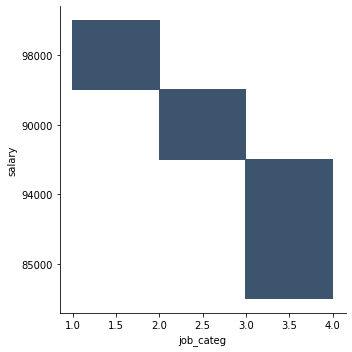

In [39]:
mock_data = [('SE', '85000'), ('Mechanical', '94000'), ('Data Sience', '98000'), ('Doctor', '90000')]
test_salary_dist_job_category(mock_data)

In [30]:
def test_salary_dist_job_category(mock_data: list, 
                              schema: list = ['Job Category', 'Salary Range To']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert salary_dist_job_category(mock_df)
